# **FaceExpreessionRecogniser using Affectnet+KDEF (Greyscaled)**
* Trained on Tesla P100-PCIE-16GB
* 100 epochs trained (~15h) with Checkpoints
* 81% val_acc (80% val_acc after 30-40 epochs)
* TF version: 2.3.1
* Hub version: 0.10.0

In [74]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

TF version: 2.4.1
Hub version: 0.11.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of accelerators:  1


In [75]:
import subprocess
import pprint

sp = subprocess.Popen(['nvidia-smi', '-q'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out_str = sp.communicate()
out_list = str(out_str[0]).split('\\n')

out_dict = {}

for item in out_list:
    print(item)

b'
==============NVSMI LOG==============

Timestamp                                 : Sun Jan 31 10:14:01 2021
Driver Version                            : 418.67
CUDA Version                              : 10.1

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : Tesla
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : Function Not Found
        Pending                           : Function Not Found
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1561620041301
    GPU UUID                              : GPU-

In [76]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
# Names of the integer classes, i.e., 0 -> afraid, 1 -> angry, etc.
class_names = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [77]:
train_dir = "/content/drive/MyDrive/cropped/Affectnet4k" 
test_val_dir = "/content/drive/MyDrive/cropped/KDEF"

In [78]:
from keras.preprocessing.image import ImageDataGenerator
train_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet.preprocess_input).flow_from_directory(directory=train_dir,target_size=(224,224),classes=class_names,batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet.preprocess_input).flow_from_directory(directory=test_val_dir,target_size=(224,224),classes=class_names,batch_size=32)

Found 23479 images belonging to 7 classes.
Found 1120 images belonging to 7 classes.


In [79]:
imgs,labels = next(valid_batches)

In [80]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 32, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

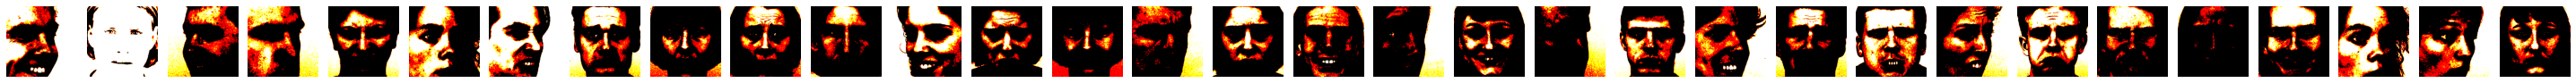

In [81]:
plotImages(imgs)

In [82]:
for l in labels:
    maximum = np.max(l)
    index_of_maximum = np.where(l == maximum)
    
    print(class_names[index_of_maximum[0][0]])

happy
sad
happy
angry
disgusted
afraid
disgusted
sad
afraid
afraid
neutral
happy
sad
happy
angry
afraid
happy
surprised
happy
angry
neutral
happy
afraid
angry
afraid
sad
disgusted
sad
happy
surprised
surprised
neutral


In [83]:
# import math
# datagen_kwargs = dict(rescale=1./255)
# dataflow_kwargs = dict(color_mode="rgb",target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#                    interpolation="bilinear")

# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     **datagen_kwargs, validation_split=0.99)
# valid_generator = valid_datagen.flow_from_directory(
#     test_val_dir, subset="validation", shuffle=False, **dataflow_kwargs) #test_val_dir

# do_data_augmentation = True #@param {type:"boolean"}
# if do_data_augmentation:
#   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#       rotation_range=40,
#       horizontal_flip=True,
#       width_shift_range=0.2, 
#       height_shift_range=0.2,
#       shear_range=0.2, zoom_range=0.2,
#       **datagen_kwargs)
# else:
#   train_datagen = valid_datagen
# train_generator = train_datagen.flow_from_directory(
#     train_dir, subset="training", shuffle=True, **dataflow_kwargs) #train_dir


# number_of_valid_examples = len(valid_generator.filenames)
# number_of_generator_calls = math.ceil(number_of_valid_examples / (1.0 * BATCH_SIZE)) 
# # 1.0 above is to skip integer division

# valid_labels = []

# for i in range(0,int(number_of_generator_calls)):
#     valid_labels.extend(np.array(valid_generator[i][1]))

In [84]:
do_fine_tuning = True #@param {type:"boolean"}

In [85]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning), # False = transfer learning, True = fine-tuning
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu') ,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512*2,activation='relu'),#we add dense layers so that the model can learn more complex functions and classify for better results.
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_batches.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])  
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
____________________________

# New Section

In [86]:
from keras.callbacks import ModelCheckpoint
#Atutomatic rename with epoch number and val accuracy:
#save the best weights over the same file with the model name
modelName= "MobileNet"
#filepath="checkpoints/"+modelName+"_bestweights_epoch-{epoch:02d}-val_accuracy-{val_accuracy:.2f}.hdf5"
filepath=modelName+"_bestweights_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model

In [ ]:
steps_per_epoch = train_batches.samples // train_batches.batch_size  #train_generator.samples = num_of_train_samples
validation_steps = valid_batches.samples // valid_batches.batch_size #valid_generator.samples = num_of_valid_samples
# Train the classifier.
hist = model.fit(train_batches, 
                 epochs=100, 
                 steps_per_epoch= steps_per_epoch, 
                 validation_data=valid_batches,
                 callbacks=callbacks_list,
                 validation_steps=validation_steps).history

Epoch 1/100
733/733 [==============================] - 8398s 11s/step - loss: 1.9286 - accuracy: 0.2673 - val_loss: 1.1662 - val_accuracy: 0.7446

Epoch 00001: val_accuracy improved from -inf to 0.74464, saving model to MobileNet_bestweights_epochs:001-val_accuracy:0.745.hdf5
Epoch 2/100
733/733 [==============================] - 162s 221ms/step - loss: 1.5256 - accuracy: 0.5159 - val_loss: 1.0116 - val_accuracy: 0.7812

Epoch 00002: val_accuracy improved from 0.74464 to 0.78125, saving model to MobileNet_bestweights_epochs:002-val_accuracy:0.781.hdf5
Epoch 3/100
733/733 [==============================] - 164s 224ms/step - loss: 1.3964 - accuracy: 0.5872 - val_loss: 0.9478 - val_accuracy: 0.8161

Epoch 00003: val_accuracy improved from 0.78125 to 0.81607, saving model to MobileNet_bestweights_epochs:003-val_accuracy:0.816.hdf5
Epoch 4/100
733/733 [==============================] - 164s 224ms/step - loss: 1.3185 - accuracy: 0.6288 - val_loss: 1.0163 - val_accuracy: 0.7679

Epoch 00004: 

# Train the saved model

In [ ]:
# import numpy as np
# from numpy.testing import assert_allclose
# from keras.models import Sequential, load_model
# from keras.layers import LSTM, Dropout, Dense
# from keras.callbacks import ModelCheckpoint
# from tensorflow.keras.models import model_from_json
# import tensorflow_hub as hub

# reloaded_model =  tf.keras.models.load_model('../input/faceexprafterfirstcheckpoint/epochs_038-val_accuracy_0.809.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
# print(reloaded_model.get_config())

# #Get input shape from model.get_config()
# reloaded_model.build((None, 224, 224, 3))
# reloaded_model.summary()

# steps_per_epoch = train_generator.samples // train_generator.batch_size  #train_generator.samples = num_of_train_samples
# validation_steps = valid_generator.samples // valid_generator.batch_size #valid_generator.samples = num_of_valid_samples
# # Train the classifier.
# hist = reloaded_model.fit(train_generator, 
#                  epochs=43, 
#                  steps_per_epoch= steps_per_epoch, 
#                  validation_data=valid_generator,
#                  callbacks=callbacks_list,
#                  validation_steps=validation_steps).history

 Save the model and last weights 

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_json = model.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

# SAVING

In [ ]:
import fileinput
# Saving the model in the workspace
model.save('MobileNet-Kaggle.h5')

In [ ]:
# # load json and create model
# json_file = open('20190107_220958_InceptionTutorial_MODEL_3.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)

In [ ]:
# # load weights into new model
# model.load_weights("InceptionTutorial_bestweights.hdf5")

# Model Acc&Loss + Confusion Matrix

In [ ]:
# # list all data in history
# print(hist.history())

# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylim([0,2])
plt.title('model loss')
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# # list all data in history
print(hist.keys())

# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylim([0,2])
plt.title('model loss')
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Y_pred = model.predict(valid_batches, valid_batches.samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_batches.classes, y_pred)
print(cm)
print('Classification Report')
target_names = list(train_batches.class_indices.keys())
print(classification_report(valid_batches.classes, y_pred, target_names=target_names))


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=valid_batches.classes)

# make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Testing

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
# from skimage import transform
import cv2
import sys


    


# # Names of the integer classes, i.e., 0 -> afraid, 1 -> angry, etc.
class_names = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

def load(filePath):
    image = cv2.imread(filePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )

#     print("[INFO] Found {0} Faces.".format(len(faces)))
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 224, 0), 2)
        roi_color = image[y:y + h, x:x + w]
        np_image = image
        np_image = np.array(np_image).astype('float32')/255
        np_image = np.resize(np_image, (224, 224, 3))
        np_image = np.expand_dims(np_image, axis=0)
        model.predict(np_image)        #change here the model
        x = class_names
        plt.imshow(image)
        plt.axis('off')
        y_pred=model.predict(np_image)
#         print(x[np.argmax(y_pred,axis=1)[0]]) #model.predict_classes(image) is a 1 element array with the result of the prediction
        plt.text(3, 8, x[np.argmax(y_pred,axis=1)[0]], fontsize=15, style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
        plt.show()

for filename in os.listdir("../input/faceexprtestimages/DorinNet/DorinNet/"):
    if filename.endswith(".jpg"): 
#         classify(os.path.join("../input/faceexprtestimages/DorinNet/DorinNet/", filename))
        load(os.path.join("../input/faceexprtestimages/DorinNet/DorinNet/", filename))
        continue
    else:
        continue

In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_batches.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))